<a href="https://colab.research.google.com/github/woojin9605/Practice/blob/main/FCN_32_16_8s_real_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive' , force_remount=True)

Mounted at /content/drive


In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import models
from torchvision.models.vgg import VGG
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from torch.autograd import Variable
import torchvision
import torchvision.utils as vutils
import torch.nn.functional as F
from torch.backends import cudnn

cudnn.benchmark = True

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def get_upsampling_weight(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2 # 이로써 2 x upsample이 bilinear역할을 할 수 있음 it performs a bilinear interpolation.
    #By bilinear weights I mean initializing the DeConvLayer weights so it replicates a standard bilinear image upsampling (resampling)
    #논문에서 이렇게 초기화함
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size] # 해당 사이즈만큼 순서대로 축 값을 가지는 배열생성
    #[array([[0],
    #   [1],
    #   [2]]), array([[0, 1, 2]])] 예시와 같이 두가지 축에 대해서 grid배열 생성
    filt = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size), dtype=np.float64)
    weight[list(range(in_channels)), list(range(out_channels)), :, :] = filt
    return torch.from_numpy(weight).float()

class FCN32s(nn.Module):
  def __init__(self, num_classes, pretrained=True):
    super().__init__()
    vgg16 = models.vgg16(pretrained=True)
    features, classifier = list(vgg16.features.children()), list(vgg16.classifier.children())
    features[0].padding = (100, 100)
    for f in features:
      if 'MaxPool' in f.__class__.__name__:
        f.ceil_mode = True
      elif 'ReLU' in f.__class__.__name__:
        f.inplace = True

    self.features5 = nn.Sequential(*features)

    fc6 = nn.Conv2d(512, 4096, kernel_size=7)
    fc6.weight.data.copy_(classifier[0].weight.data.view(4096, 512, 7, 7))
    fc6.bias.data.copy_(classifier[0].bias.data)

    fc7 = nn.Conv2d(4096, 4096, kernel_size=1)
    fc7.weight.data.copy_(classifier[3].weight.data.view(4096, 4096, 1, 1))
    fc7.bias.data.copy_(classifier[3].bias.data)

    score_fr = nn.Conv2d(4096, num_classes, kernel_size=1)
    score_fr.weight.data.zero_()
    score_fr.bias.data.zero_()

    self.score_fr = nn.Sequential(fc6, nn.ReLU(inplace=True), nn.Dropout(), 
                                  fc7, nn.ReLU(inplace=True), nn.Dropout(), score_fr)
    self.upscore = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=64, stride=32, bias=False)
    self.upscore.weight.data.copy_(get_upsampling_weight(num_classes, num_classes, 64)) 

  def forward(self, x):
    x_size = x.size()
    pool5 = self.features5(x)
    score_fr = self.score_fr(pool5)
    upscore = self.upscore(score_fr)
    return upscore[:, :, 19: (19 + x_size[2]), 19: (19 + x_size[3])].contiguous()

class FCN16s(nn.Module):
  def __init__(self, num_classes, pretrained=True):
    super().__init__()
    vgg16 = models.vgg16(pretrained=True)
    features, classifier = list(vgg16.features.children()), list(vgg16.classifier.children())
    features[0].padding = (100, 100)
    for f in features:
      if 'MaxPool' in f.__class__.__name__:
        f.ceil_mode = True
      elif 'ReLU' in f.__class__.__name__:
        f.inplace = True

    self.features4 = nn.Sequential(*features[: 24])
    self.features5 = nn.Sequential(*features[24: ])

    self.score_pool4 = nn.Conv2d(512, num_classes, kernel_size=1)


    fc6 = nn.Conv2d(512, 4096, kernel_size=7)
    fc6.weight.data.copy_(classifier[0].weight.data.view(4096, 512, 7, 7))
    fc6.bias.data.copy_(classifier[0].bias.data)

    fc7 = nn.Conv2d(4096, 4096, kernel_size=1)
    fc7.weight.data.copy_(classifier[3].weight.data.view(4096, 4096, 1, 1))
    fc7.bias.data.copy_(classifier[3].bias.data)

    score_fr = nn.Conv2d(4096, num_classes, kernel_size=1)
    score_fr.weight.data.zero_()
    score_fr.bias.data.zero_()

    self.score_fr = nn.Sequential(fc6, nn.ReLU(inplace=True), nn.Dropout(), 
                                  fc7, nn.ReLU(inplace=True), nn.Dropout(), score_fr)
    
    self.upscore_2 =  nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, bias=False)
    self.upscore_16 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=32, stride=16, bias=False)
    self.upscore_2.weight.data.copy_(get_upsampling_weight(num_classes, num_classes, 4))
    self.upscore_16.weight.data.copy_(get_upsampling_weight(num_classes, num_classes, 32))
  
  def forward(self, x):
    x_size = x.size()
    pool4 = self.features4(x)
    pool5 = self.features5(pool4)

    score_fr = self.score_fr(pool5)
    upscore_2 = self.upscore_2(score_fr)

    score_pool4 = self.score_pool4(pool4)
    #print(upscore_2.shape,score_pool4[:, :, 5: (5 + upscore_2.size()[2]), 5: (5 + upscore_2.size()[3])].shape)
    
    score_sum = upscore_2 + score_pool4[:, :, 5: (5 + upscore_2.size()[2]), 5: (5 + upscore_2.size()[3])]

    upscore_16 = self.upscore_16(score_sum)

    return upscore_16[:, :, 27: (27 + x_size[2]), 27: (27 + x_size[3])].contiguous()

class FCN8s(nn.Module):
  def __init__(self, num_classes, pretrained=True):
    super().__init__()
    vgg16 = models.vgg16(pretrained=True)
    features, classifier = list(vgg16.features.children()), list(vgg16.classifier.children())
    features[0].padding = (100, 100)
    for f in features:
      if 'MaxPool' in f.__class__.__name__:
        f.ceil_mode = True
      elif 'ReLU' in f.__class__.__name__:
        f.inplace = True

    self.features3 = nn.Sequential(*features[: 17])
    self.features4 = nn.Sequential(*features[17: 24])
    self.features5 = nn.Sequential(*features[24: ])

    self.score_pool3 = nn.Conv2d(256, num_classes, kernel_size=1)
    self.score_pool4 = nn.Conv2d(512, num_classes, kernel_size=1)

    fc6 = nn.Conv2d(512, 4096, kernel_size=7)
    fc6.weight.data.copy_(classifier[0].weight.data.view(4096, 512, 7, 7))
    fc6.bias.data.copy_(classifier[0].bias.data)

    fc7 = nn.Conv2d(4096, 4096, kernel_size=1)
    fc7.weight.data.copy_(classifier[3].weight.data.view(4096, 4096, 1, 1))
    fc7.bias.data.copy_(classifier[3].bias.data)

    score_fr = nn.Conv2d(4096, num_classes, kernel_size=1)
    score_fr.weight.data.zero_()
    score_fr.bias.data.zero_()

    self.score_fr = nn.Sequential(fc6, nn.ReLU(inplace=True), nn.Dropout(), 
                                  fc7, nn.ReLU(inplace=True), nn.Dropout(), score_fr)
    
    self.upscore_2_1 =  nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, bias=False)
    self.upscore_2_2 =  nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, bias=False)
    self.upscore_8 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=16, stride=8, bias=False)

    self.upscore_2_1.weight.data.copy_(get_upsampling_weight(num_classes, num_classes, 4))
    self.upscore_2_2.weight.data.copy_(get_upsampling_weight(num_classes, num_classes, 4))
    self.upscore_8.weight.data.copy_(get_upsampling_weight(num_classes, num_classes, 16))
  
  def forward(self, x):
    x_size = x.size()
    pool3 = self.features3(x)
    pool4 = self.features4(pool3)
    pool5 = self.features5(pool4)

    score_fr = self.score_fr(pool5)
    upscore_2_1 = self.upscore_2_1(score_fr)
    score_pool4 = self.score_pool4(pool4)
    #print(upscore_2.shape,score_pool4[:, :, 5: (5 + upscore_2.size()[2]), 5: (5 + upscore_2.size()[3])].shape)
    score_sum_1 = upscore_2_1 + score_pool4[:, :, 5: (5 + upscore_2_1.size()[2]), 5: (5 + upscore_2_1.size()[3])]

    upscore_2_2 = self.upscore_2_2(score_sum_1)
    score_pool3 = self.score_pool3(pool3)

    #print(upscore_2_2.shape,score_pool3[:, :, 5: (5 + upscore_2_2.size()[2]), 5: (5 + upscore_2_2.size()[3])].shape)
    score_sum_2 = upscore_2_2 + score_pool3[:, :, 9: (9 + upscore_2_2.size()[2]), 9: (9 + upscore_2_2.size()[3])]
    upscore_8 = self.upscore_8(score_sum_2)

    return upscore_8[:, :, 31: (31 + x_size[2]), 31: (31 + x_size[3])].contiguous()

In [49]:
root = '/content/drive/MyDrive/datasets/VOCdevkit/VOC2011'

batch_size = 8

tf = transforms.Compose([
              transforms.Resize((256,256),0),
              transforms.ToTensor()
])
ttf = transforms.Compose([
              transforms.Resize((256,256),0)
])

def make_dataset(mode):
    assert mode in ['train', 'val']
    items = []
    if mode == 'train':
        img_path = os.path.join(root, 'JPEGImages')
        mask_path = os.path.join(root, 'SegmentationClass')
        data_list = [l.strip('\n') for l in open(os.path.join(
            root,'ImageSets', 'Segmentation', 'train.txt')).readlines()]
        for it in data_list:
            item = (os.path.join(img_path, it + '.jpg'), os.path.join(mask_path, it + '.png'))
            items.append(item)
    elif mode == 'val':
        img_path = os.path.join(root, 'JPEGImages')
        mask_path = os.path.join(root, 'SegmentationClass')
        data_list = [l.strip('\n') for l in open(os.path.join(
            root,'ImageSets', 'Segmentation', 'val.txt')).readlines()]
        for it in data_list:
            item = (os.path.join(img_path, it + '.jpg'), os.path.join(mask_path, it + '.png'))
            items.append(item)
    return items
    
class VOC(torch.utils.data.Dataset):
    def __init__(self, mode, transform=None, target_transform=None):
        self.imgs = make_dataset(mode)
        if len(self.imgs) == 0:
          raise RuntimeError('no images')
        self.mode = mode
        self.transforms = transform
        self.target_transforms = target_transform

    def __getitem__(self, idx):
        img_path, mask_path = self.imgs[idx]
        img = Image.open(os.path.join(img_path)).convert('RGB')
        mask = Image.open(mask_path)
        mask = np.array(mask)
        obj_ids = np.arange(21)
        masks = mask == obj_ids[:, None, None]
        
        #import pdb; pdb.set_trace() 
        masks = torch.as_tensor(masks, dtype=torch.float32)
        if self.transforms and self.target_transforms is not None:
            img = self.transforms(img)
            masks = self.target_transforms(masks)
        return img, masks

    def __len__(self):
        return len(self.imgs)

dataset = VOC(mode='train',transform=tf, target_transform=ttf)
dataset_val = VOC(mode='val',transform=tf, target_transform=ttf)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers= 4)

In [ ]:
img, masks = dataset_val[24]
print(masks)
im = transforms.ToPILImage()(img).convert("RGB")
display(im)
print(im)
print(im.size)

In [51]:
num_classes = 21

fcn_model32 =  FCN32s(num_classes)
fcn_model16 =  FCN16s(num_classes)
fcn_model8 =  FCN8s(num_classes)

epochs = 300
lr = 1e-4
betas = [0.9, 0.999]

criterion = nn.BCELoss().cuda()

In [ ]:
model_state_dict1 = torch.load('/content/drive/MyDrive/Colab_Projects/FCN/fcn_32s.pt') # pre-trained parameters
fcn_model32.load_state_dict(model_state_dict1) # load pre-trained parameters
fcn_model = fcn_model32
fcn_model = fcn_model.cuda()
optimizer = optim.Adam(fcn_model.parameters(), lr=lr, betas=betas) 
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=20,gamma=0.1)

t = 0
fcn_model.train()

for epo in range(50):
  index = 0
  epo_loss = 0
  for img, masks in dataloader:
      t += 1
      index += 1
      input = img
      #import pdb; pdb.set_trace()
      N = input.size(0)
      y = masks
      input = torch.autograd.Variable(input)
      y = torch.autograd.Variable(y)

      input = input.cuda()
      y = y.cuda()

      optimizer.zero_grad()
      output = fcn_model(input)

      output = torch.sigmoid(output)
      loss = criterion(output, y)
      loss.backward()
      iter_loss = loss.data
      epo_loss += iter_loss
      optimizer.step()
      output_np = output.cpu().data.numpy().copy()
      output_np = output_np * 255
      y_np = y.cpu().data.numpy().copy()
      y_np = y_np * 255
      output_np = torch.as_tensor(output_np, dtype=torch.uint8)
      y_np = torch.as_tensor(y_np, dtype=torch.uint8)
      image1 = Image.fromarray(output_np[0,0,:, :].byte().numpy())
      image2 = Image.fromarray(y_np[0,0, :, :].byte().cpu().numpy())

      if index%8 == 0:
        print('epoch {}, {}/{}, loss is {}'.format(epo, index, len(dataloader), iter_loss))
        plt.subplot(1, 2, 1) 
        plt.imshow(image1, 'gray')
        plt.subplot(1, 2, 2) 
        plt.imshow(image2, 'gray')
        plt.show()
  lr_scheduler.step()
  #torch.save(fcn_model.state_dict(),'/content/drive/MyDrive/Colab_Projects/FCN/fcn_32s.pt')
print('epoch loss = %f'%(epo_loss/len(dataloader)))

In [ ]:
model_state_dict2 = torch.load('/content/drive/MyDrive/Colab_Projects/FCN/fcn_16s.pt') # pre-trained parameters
fcn_model16.load_state_dict(model_state_dict2) # load pre-trained parameters
fcn_model = fcn_model16
fcn_model = fcn_model.cuda()
optimizer = optim.Adam(fcn_model.parameters(), lr=lr, betas=betas)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=20,gamma=0.1)

t = 0
fcn_model.train()

for epo in range(50):
  index = 0
  epo_loss = 0
  for img, masks in dataloader:
      t += 1
      index += 1
      input = img
      y = masks
      input = torch.autograd.Variable(input)
      y = torch.autograd.Variable(y)

      input = input.cuda()
      y = y.cuda()

      optimizer.zero_grad()
      output = fcn_model(input)
      output = torch.sigmoid(output)
      #import pdb; pdb.set_trace()
      loss = criterion(output, y)
      loss.backward()
      iter_loss = loss.data
      epo_loss += iter_loss
      optimizer.step()
      output_np = output.cpu().data.numpy().copy()
      output_np = output_np * 255
      y_np = y.cpu().data.numpy().copy()
      y_np = y_np * 255
      output_np = torch.as_tensor(output_np, dtype=torch.uint8)
      y_np = torch.as_tensor(y_np, dtype=torch.uint8)
      image1 = Image.fromarray(output_np[0,0,:, :].byte().numpy())
      image2 = Image.fromarray(y_np[0,0, :, :].byte().cpu().numpy())

      if index%10 == 0:
        print('epoch {}, {}/{}, loss is {}'.format(epo, index, len(dataloader), iter_loss))
        plt.subplot(1, 2, 1) 
        plt.imshow(image1, 'gray')
        plt.subplot(1, 2, 2) 
        plt.imshow(image2, 'gray')
        plt.show()
  lr_scheduler.step()
  #torch.save(fcn_model.state_dict(),'/content/drive/MyDrive/Colab_Projects/FCN/fcn_16s.pt')
print('epoch loss = %f'%(epo_loss/len(dataloader)))

In [ ]:
model_state_dict3 = torch.load('/content/drive/MyDrive/Colab_Projects/FCN/fcn_8s.pt') # pre-trained parameters
fcn_model8.load_state_dict(model_state_dict3) # load pre-trained parameters
fcn_model = fcn_model8
fcn_model = fcn_model.cuda()
optimizer = optim.Adam(fcn_model.parameters(), lr=lr, betas=betas)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=20,gamma=0.1)

t = 0
fcn_model.train()

for epo in range(50):
  index = 0
  epo_loss = 0
  for img, masks in dataloader:
      t += 1
      index += 1
      input = img
      y = masks
      input = torch.autograd.Variable(input)
      y = torch.autograd.Variable(y)

      input = input.cuda()
      y = y.cuda()

      optimizer.zero_grad()
      output = fcn_model(input)
      output = torch.sigmoid(output)
      loss = criterion(output, y)
      loss.backward()
      iter_loss = loss.data
      epo_loss += iter_loss
      optimizer.step()
      output_np = output.cpu().data.numpy().copy()
      output_np = output_np * 255
      y_np = y.cpu().data.numpy().copy()
      y_np = y_np * 255
      output_np = torch.as_tensor(output_np, dtype=torch.uint8)
      y_np = torch.as_tensor(y_np, dtype=torch.uint8)
      image1 = Image.fromarray(output_np[0,0,:, :].byte().numpy())
      image2 = Image.fromarray(y_np[0,0, :, :].byte().cpu().numpy())

      if index%10 == 0:
        print('epoch {}, {}/{}, loss is {}'.format(epo, index, len(dataloader), iter_loss))
        plt.subplot(1, 2, 1) 
        plt.imshow(image1, 'gray')
        plt.subplot(1, 2, 2) 
        plt.imshow(image2, 'gray')
        plt.show()
  lr_scheduler.step()
  #torch.save(fcn_model.state_dict(),'/content/drive/MyDrive/Colab_Projects/FCN/fcn_8s.pt')
print('epoch loss = %f'%(epo_loss/len(dataloader)))

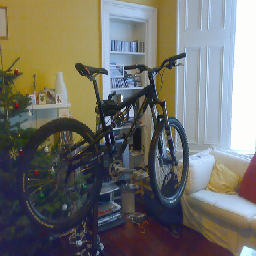

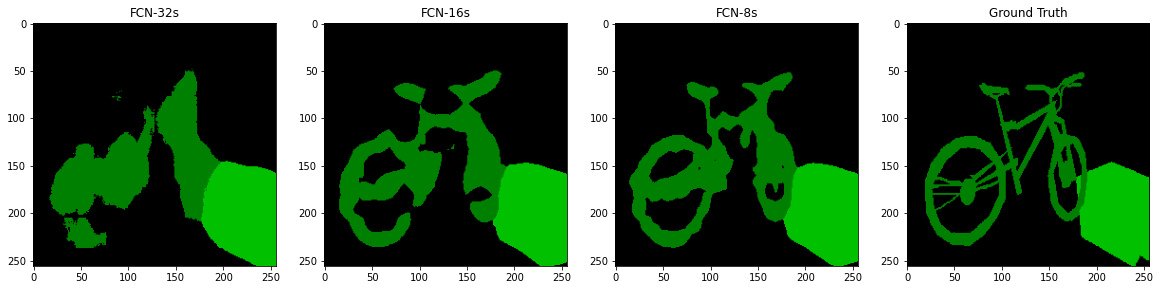

In [80]:
fcn_model32 =  FCN32s(num_classes)
fcn_model16 =  FCN16s(num_classes)
fcn_model8 =  FCN8s(num_classes)

palette = [0, 0, 0, 128, 0, 0, 0, 128, 0, 128, 128, 0, 0, 0, 128, 128, 0, 128, 0, 128, 128,
           128, 128, 128, 64, 0, 0, 192, 0, 0, 64, 128, 0, 192, 128, 0, 64, 0, 128, 192, 0, 128,
           64, 128, 128, 192, 128, 128, 0, 64, 0, 128, 64, 0, 0, 192, 0, 128, 192, 0, 0, 64, 128]

model_state_dict1 = torch.load('/content/drive/MyDrive/Colab_Projects/FCN/fcn_32s.pt') # pre-trained parameters
fcn_model32.load_state_dict(model_state_dict1) # load pre-trained parameters
fcn_model32 = fcn_model32.cuda()

model_state_dict2 = torch.load('/content/drive/MyDrive/Colab_Projects/FCN/fcn_16s.pt') # pre-trained parameters
fcn_model16.load_state_dict(model_state_dict2) # load pre-trained parameters
fcn_model16 = fcn_model16.cuda()

model_state_dict3 = torch.load('/content/drive/MyDrive/Colab_Projects/FCN/fcn_8s.pt') # pre-trained parameters
fcn_model8.load_state_dict(model_state_dict3) # load pre-trained parameters
fcn_model8 = fcn_model8.cuda()

fcn_model32.eval()
fcn_model16.eval()
fcn_model8.eval()

indexx = 19

img, mask = dataset[indexx]
#img, mask = dataset_val[indexx]
output32 = fcn_model32(img.unsqueeze(0).cuda())
output16 = fcn_model16(img.unsqueeze(0).cuda())
output8 = fcn_model8(img.unsqueeze(0).cuda())

output32 = torch.sigmoid(output32)
output16 = torch.sigmoid(output16)
output8 = torch.sigmoid(output8)

im = transforms.ToPILImage()(img).convert("RGB")
display(im)
'''
color map
0=background,    1=aeroplane,    2=bicycle,  3=bird,    4=boat, 
5=bottle         6=bus,          7=car,      8=cat,     9=chair, 
10=cow,          11=diningtable, 12=dog,     13=horse,  14=motorbike,  15=person 
16=potted plant, 17=sheep,       18=sofa,    19=train,  20=tv/monitor
'''
output_np32 = output32.cpu().data.numpy().copy()
output_np16 = output16.cpu().data.numpy().copy()
output_np8 = output8.cpu().data.numpy().copy()
output_np32 = output_np32 * 255
output_np16 = output_np16 * 255
output_np8 = output_np8 * 255
output_np32 = torch.as_tensor(output_np32, dtype=torch.uint8)
output_np16 = torch.as_tensor(output_np16, dtype=torch.uint8)
output_np8 = torch.as_tensor(output_np8, dtype=torch.uint8)

output_np32 = torch.argmax(output_np32,dim=1)
output_np16 = torch.argmax(output_np16,dim=1)
output_np8 = torch.argmax(output_np8,dim=1)

image32 = Image.fromarray(output_np32[0,:,:].byte().numpy())
image16 = Image.fromarray(output_np16[0,:,:].byte().numpy())
image8 = Image.fromarray(output_np8[0,:,:].byte().numpy())
mask = mask.cuda()
y = mask.unsqueeze(0)
y = torch.argmax(y, dim=1)
y_np = y.cpu().data.numpy().copy()
y_np = y_np
y_np = torch.as_tensor(y_np, dtype=torch.uint8)
gt = Image.fromarray(y_np[0,:,:].byte().numpy())

image32.putpalette(palette)
image16.putpalette(palette)
image8.putpalette(palette)
gt.putpalette(palette)

plt.figure(figsize=(20,10))
plt.subplot(1, 4, 1) 
plt.title('FCN-32s')
plt.imshow(image32)
plt.subplot(1, 4, 2) 
plt.title('FCN-16s')
plt.imshow(image16)
plt.subplot(1, 4, 3)
plt.title('FCN-8s')
plt.imshow(image8)
plt.subplot(1, 4, 4)
plt.title('Ground Truth')
plt.imshow(gt)
plt.show()